In [ ]:
! pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 57.9 MB/s eta 0:00:00


In [151]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor



from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error




from math import cos, sin
import os
import pickle

# Getting Data Ready

## Downloading and Unzipping

In [ ]:
#!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [ ]:
#!mv '/content/AFLW2000-3D.zip' '/content/drive/MyDrive/ML 1 Project'

In [ ]:
!cp -r '/content/drive/MyDrive/ML 1 Project' $PWD

In [ ]:
!unzip '/content/ML 1 Project/AFLW2000-3D.zip'

In [ ]:
!rm '/content/ML 1 Project/AFLW2000-3D.zip'

In [ ]:
! ls '/content/AFLW2000'

## Extracting Landmarks

Based on certain landmarks from the face such as the location of the nose, eyes, forhead, etc..., we can detect the 3 angles around the axes (x,y,z), those angles (pitch, yaw roll) can estimate the position of the head w.r.t to the axes. The location of each landmark can be described using its location on the x and y axis. So we want to extract the location of these features, in this section we will perform such that!

In [ ]:
#getting a list of all files names and sorting it
files = os.listdir('/content/AFLW2000')
files.sort()
print(files)

In [ ]:
# there is a folder called "Code" which is not needed, so it will be removed
del files[0]
print(files)

In [ ]:
# there's two file types .jpg and .mat, we will create two seperate lists to hold the file names of each type
jpg_files = [name for name in files if name.split('.')[1] == 'jpg']
mat_files = [name for name in files if name.split('.')[1] == 'mat']
print('.jpg File Names: ', jpg_files)
print('.mat File Names: ', mat_files)

The mediapipe module provides a model that is able to detect the landmarks for us. But if we think about it, we don't actually need all the landmarks from the face to be able to determine the 3 mentioned angles, so we will select certain landmarks such as the nose, left and right eyes, left and right eyebrows, etc...

In [ ]:
# set up face mesh module
face_module = mp.solutions.face_mesh

# initialize arrays for features and labels
X = []
y = []
labels = []
image_names = []

# iterate over image and mat files
for img_path, mat_path in zip(jpg_files, mat_files):
    # read image and mat file
    img = cv2.imread('/content/AFLW2000/' + img_path)
    mat = sio.loadmat('/content/AFLW2000/' + mat_path)

    

    # create face mesh object
    with face_module.FaceMesh(static_image_mode=True) as face_mesh:
        # process image for the face_mesh model
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # check if face landmarks were detected
        if results.multi_face_landmarks:
            X_temp = []
            y_temp = []
            # get pose parameters (labels)
            pose_para = mat['Pose_Para'][0][:3]
            # save image name
            image_names.append(img_path) 
            # get face landmarks for all detected faces
            for face_landmarks in results.multi_face_landmarks:
                # initialize array for this set of landmarks
                shape = img.shape
                for landmark in face_landmarks.landmark:
                    # get landmark coordinates and add to landmarks list
                    relative_x = int(landmark.x * shape[1])
                    relative_y = int(landmark.y * shape[0])
                    X_temp.append(relative_x)
                    y_temp.append(relative_y)

                # add landmarks to feature array and pose parameters to label array
                X.append(X_temp)
                y.append(y_temp)
                labels.append(pose_para)

# convert feature and label arrays to numpy arrays
X = np.array(X)
y = np.array(y)
labels = np.array(labels)
image_names = np.array(image_names)


# check shapes
print(X.shape)
print(y.shape)
print(labels.shape)
print(image_names.shape)

(1853, 468)
(1853, 468)
(1853, 3)
(1853,)


## Saving np Arrays

In [ ]:
# we will save the np arrays for easier loading
np.save('X_points.npy', X)
np.save('y_points.npy', y)
np.save('labels.npy', labels)
np.save('image_names.npy', image_names)

In [ ]:
# load the np arrays
X_points = np.load('/content/X_points.npy')
y_points = np.load('/content/y_points.npy')
labels = np.load('/content/labels.npy')
image_names = np.load('/content/image_names.npy')


# check shapes
print(X_points.shape)
print(y_points.shape)
print(labels.shape)
print(image_names.shape)

(1853, 468)
(1853, 468)
(1853, 3)
(1853,)


# Data Exploration & Visualization

In this section we aim to understand data furthermore, and to look at the detected landamrks in the first section, as well as visualizing the desired output for the project.

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

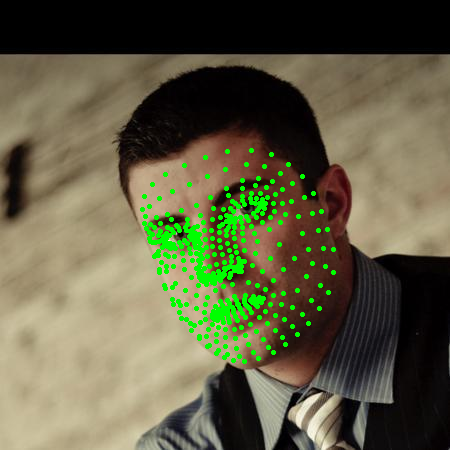

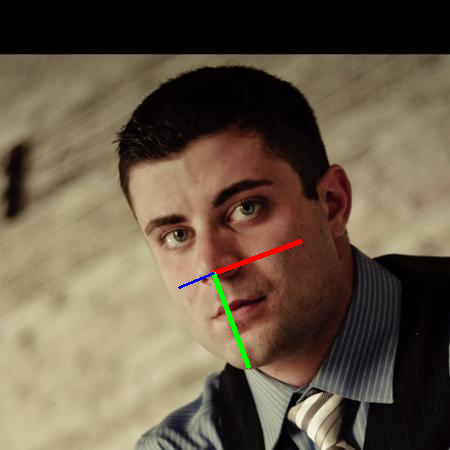

In [97]:
# drawing the deteced landmarks and the actual labels (pitch, yaw, roll) for an image
index = 10
img = cv2.imread('/content/AFLW2000/' + image_names[index])
img_copy = img.copy()

for relative_x, relative_y in zip(X_points[index], y_points[index]):
  cv2.circle(img_copy, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)

cv2_imshow(img_copy)

cv2_imshow(draw_axis(img, labels[index][0], labels[index][1], labels[index][2], X_points[:, 1][index], y_points[:, 1][index]))

## Data Pre-processing

In [ ]:
print('X points range from {} to {}'.format(X_points.min(), X_points.max()))
print('y points range from {} to {}'.format(y_points.min(), y_points.max()))
print('Labels range from {:.2f} to {:.2f}'.format(labels.min(), labels.max()))

X points range from 4 to 488
y points range from -26 to 429
Labels range from -16.97 to 15.60


As seen, the range of the data is not the same scale, so the data need to be normalized.

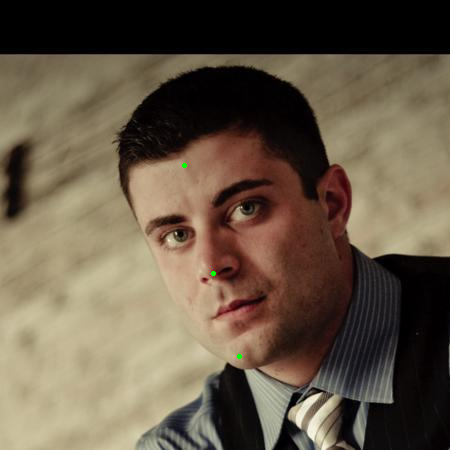

In [92]:
# drawing certain landmarks from the image
index = 10
img = cv2.imread('/content/AFLW2000/' + image_names[index])
cv2.circle(img, (X_points[index, 1],y_points[index, 1]), radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(img, (X_points[index, 10],y_points[index, 10]), radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(img, (X_points[index, 171],y_points[index, 171]), radius=1, color=(0, 255, 0), thickness=2)
cv2_imshow(img)

As seen, the nose tip , the chin alongside the foehead are drawn on the image, we can use these three points to normailze our data.

We can subtract all points from the nose points, the nose point is a stable landmark that is typically used as a reference point, and subtracting it from the other landmarks can help to normalize their position and orientation. 

Furthermore, by dividing the data by the distance from the chin to the forehead, the features become normalized to a standard size, and the scale of the features can be more easily compared. This is because the distance from the chin to the forehead is a measure of the size of the face, and by normalizing the data to this measure, features from faces of different sizes can be compared more fairly.

In [93]:
# Normalizing features
Nose_centered_X = X_points - X_points[:,1].reshape(-1,1)
Nose_centered_y = y_points - y_points[:,1].reshape(-1,1)

X_171 = X_points[:,171]
X_10 = X_points[:,10]
y_171 = y_points[:,171]
y_10 = y_points[:,10]

distance = np.linalg.norm(np.array((X_10,y_10)) - np.array((X_171, y_171)),axis = 0).reshape(-1,1)
Norm_X = Nose_centered_X / distance
Norm_Y = Nose_centered_y / distance

print(Norm_X.shape)
print(Norm_Y.shape)

features = np.hstack([Norm_X,Norm_Y])
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


In [96]:
print("Features Min. Value:", features.min())
print("Features Max. Value:", features.max())

Features Min. Value: -1.0061048346297883
Features Max. Value: 1.05004714400665


As seen now all the features range from -1 to 1.

Ideally, we would have a validation set, but as we have very few training examples, we will only use a train and test sets

In [98]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, test_size=0.15, shuffle=True)

# Modelling

Since we have 3 outputs "Yaw", "Pitch", "Roll", so we have a Multi-label problem, to solve this we should fit 3 models, each model should output each label, we could this manually or we could use sklearn's MultiOutputRegressor which automatically fits one model to each output.

NOTE: Some models have a multi-label capability by default

To evaluate the different models and compare between them we will use MSE and RMSE. Lower, MSE and RMSE values indicate a better fit of the model. but RMSE has the same scale as our data, so it's easier to interpret.

In [116]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
  train_predictions = model.predict(X_train)
  predictions = model.predict(X_test)
  train_MSE = mean_squared_error(y_train, train_predictions) 
  test_MSE = mean_squared_error(y_test, predictions)
  print('Train MSE:', train_MSE)
  print('Train RMSE:', np.sqrt(train_MSE))
  print("Test MSE:", test_MSE)
  print("Test RMSE:", np.sqrt(test_MSE))

In [117]:
# fitting & evaluating a SVR model
SVR_model = MultiOutputRegressor(SVR())
SVR_model.fit(X_train, y_train)
evaluate_model(SVR_model, X_train, y_train, X_test, y_test)

Train MSE: 0.22176723994448375
Train RMSE: 0.47092169194515104
Test MSE: 0.018560534123970386
Test RMSE: 0.1362370512157775


In [118]:
# fitting & evaluating a RandomForestRegressor
# NOTE: MultiRegressor is not used here as RandomForest can be multi-label be default
RFC_model = RandomForestRegressor()
RFC_model.fit(X_train, y_train)
evaluate_model(RFC_model, X_train, y_train, X_test, y_test)

Train MSE: 0.03613989997543335
Train RMSE: 0.19010497093825124
Test MSE: 0.12853343583690355
Test RMSE: 0.35851560054885134


In [119]:
# fitting & evaluating a AdaBoostRegresor
AdaR = MultiOutputRegressor(AdaBoostRegressor())
AdaR.fit(X_train, y_train)
evaluate_model(AdaR, X_train, y_train, X_test, y_test)

Train MSE: 0.033595450460602416
Train RMSE: 0.18329061749201025
Test MSE: 0.3458195279990204
Test RMSE: 0.5880642209818757


In [120]:
# fitting & evaluating a GradientBoostingRegressor
GBR = MultiOutputRegressor(GradientBoostingRegressor())
GBR.fit(X_train, y_train)
evaluate_model(GBR, X_train, y_train, X_test, y_test)

Train MSE: 0.006616008946865131
Train RMSE: 0.08133885262815754
Test MSE: 0.40081807110729434
Test RMSE: 0.6331019436925576


As seen the model with the lowest MSE and RMSE, is Support Vector Regressor, we should take this model, and optimize it a bit further, to try and get better results.

## Model Optimization

In [130]:
label_names = ['pitch', 'yaw', 'roll']
svr_list = SVR_model.estimators_
for i, model in enumerate(svr_list):
  print(f'{label_names[i]} Model Eval')
  evaluate_model(model, X_train, y_train[:, i], X_test, y_test[:, i])
  print('\n')

pitch Model Eval
Train MSE: 0.28227482469716925
Train RMSE: 0.5312954213026584
Test MSE: 0.02096026343497217
Test RMSE: 0.14477659836787218


yaw Model Eval
Train MSE: 0.04841088951654326
Train RMSE: 0.22002474750932735
Test MSE: 0.01622018743105066
Test RMSE: 0.12735849964195817


roll Model Eval
Train MSE: 0.3346160056197387
Train RMSE: 0.5784600294054367
Test MSE: 0.018501151505888342
Test RMSE: 0.13601893804131962




Since we have 3 models, we shall optimize each one indivdually

In [138]:
# function that optimizes svr 
def svr_grid_search(X_train, y_train, params):
    # Create SVR model
    svr = SVR()
    
    # Create grid search object
    grid_search = GridSearchCV(estimator=svr, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model and best parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Print best parameters
    print('Best parameters:', best_params)
    
    return best_model

In [146]:
# performing grid-search for the pitch model
params = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}

pitch_model = svr_grid_search(X_train, y_train[:, 0], params)
evaluate_model(pitch_model, X_train, y_train[:, 0], X_test, y_test[:, 0])

Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Train MSE: 0.26811717441430993
Train RMSE: 0.5178003229183137
Test MSE: 0.01943121635132415
Test RMSE: 0.13939589789991724


In [145]:
# performing grid-search for the yaw model
params = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}

yaw_model = svr_grid_search(X_train, y_train[:, 1], params)
evaluate_model(yaw_model, X_train, y_train[:, 1], X_test, y_test[:, 1])

Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Train MSE: 0.04189100131242329
Train RMSE: 0.20467291299149307
Test MSE: 0.008139816967899942
Test RMSE: 0.09022093419988479


In [147]:
# performing grid-search for the roll model
params = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}

roll_model = svr_grid_search(X_train, y_train[:, 2], params)
evaluate_model(roll_model, X_train, y_train[:, 2], X_test, y_test[:, 2])

Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Train MSE: 0.29317851969794323
Train RMSE: 0.5414596196374604
Test MSE: 0.015543634079256281
Test RMSE: 0.12467411150377725


## Saving Models

In [153]:
# saving the model as a pikcle file
with open('pitch_model.pkl', 'wb') as f:
    pickle.dump(pitch_model, f)

with open('yaw_model.pkl', 'wb') as f:
    pickle.dump(yaw_model, f)

with open('roll_model.pkl', 'wb') as f:
    pickle.dump(roll_model, f)

# Predictions

So far we have done the following:



*   Obtained the landmarks of the face
*   Normalization
*   Trained different Models & Compared Between them
*   Optimized The best Models for Better Performance 

In this section we will start making predictions on images, videos, and live prediction using a webcam.



In [159]:
# function to detect landmarks for an image
def detect_landmarks(img):
  # set up face mesh module
  face_module = mp.solutions.face_mesh

  # initialize arrays for features
  X = []
  y = []

  # create face mesh object
  with face_module.FaceMesh(static_image_mode=True) as face_mesh:
      # process image for the face_mesh model
      results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      # check if face landmarks were detected
      if results.multi_face_landmarks:
          # get face landmarks for all detected faces
          for face_landmarks in results.multi_face_landmarks:
              # initialize array for this set of landmarks
              shape = img.shape
              for landmark in face_landmarks.landmark:
                  # get landmark coordinates and add them to X and y lists
                  relative_x = int(landmark.x * shape[1])
                  relative_y = int(landmark.y * shape[0])
                  X.append(relative_x)
                  y.append(relative_y)

  X = np.array([X])
  y = np.array([y])

  # Normalizing features
  Nose_centered_X = X - X[:,1].reshape(-1,1)
  Nose_centered_y = y - y[:,1].reshape(-1,1)

  X_171 = X[:,171]
  X_10 = X[:,10]
  y_171 = y[:,171]
  y_10 = y[:,10]
  distance = np.linalg.norm(np.array((X_10,y_10)) - np.array((X_171, y_171)),axis = 0).reshape(-1,1)
  Norm_X = Nose_centered_X / distance
  Norm_Y = Nose_centered_y / distance

  nose_x = X[:,1]
  nose_y = y[:,1]

  features = np.hstack([Norm_X,Norm_Y])

  return features, nose_x, nose_y


In [160]:
def model_predict(pitch_model, yaw_model, roll_model, features):
  # making predictions
  pitch = pitch_model.predict(features)
  yaw = yaw_model.predict(features)
  roll = roll_model.predict(features)
  return pitch, yaw, roll

In [161]:
def perform_prediction(pitch_model, yaw_model, roll_model, img):
  features, nose_x, nose_y = detect_landmarks(img)
  pitch, yaw, roll = model_predict(pitch_model, yaw_model, roll_model, features)
  frame = draw_axis(img, pitch, yaw, roll, nose_x, nose_y)
  return frame

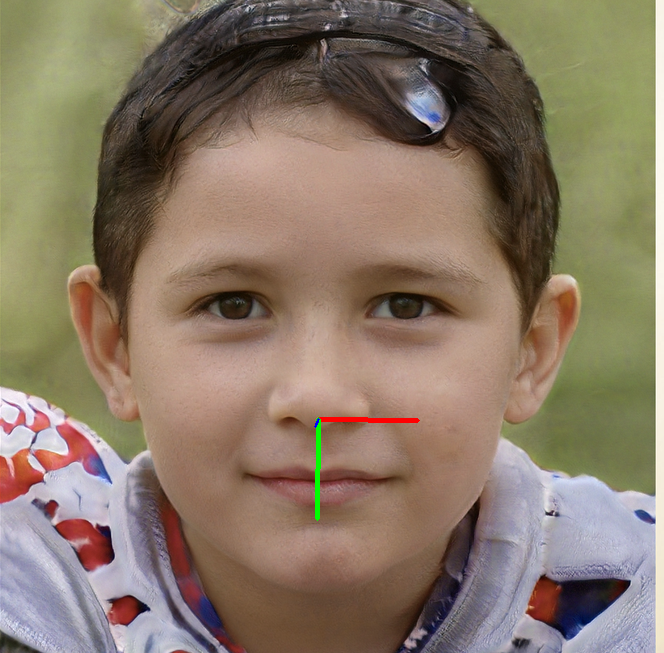

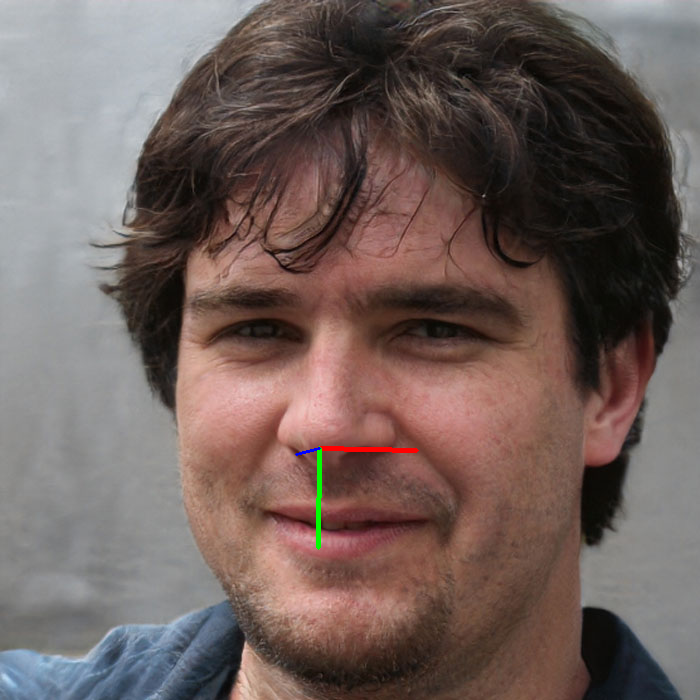

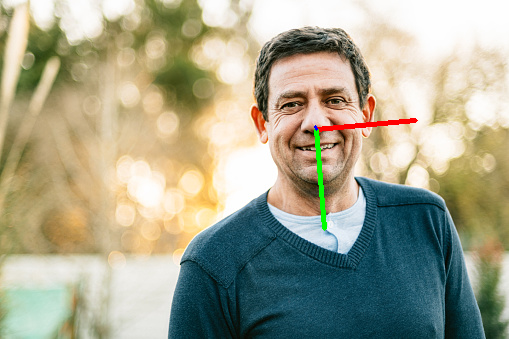

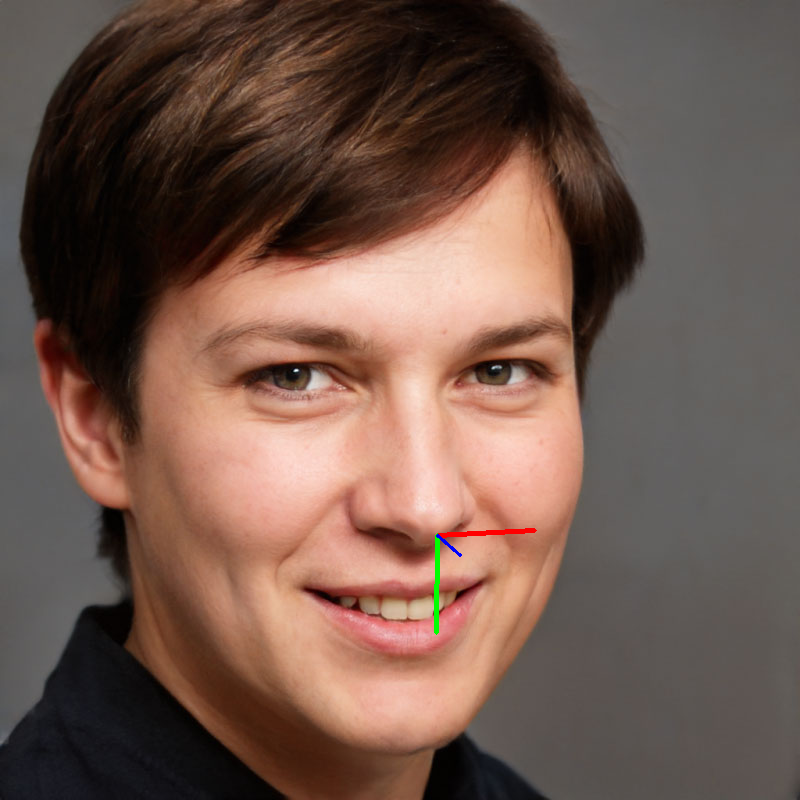

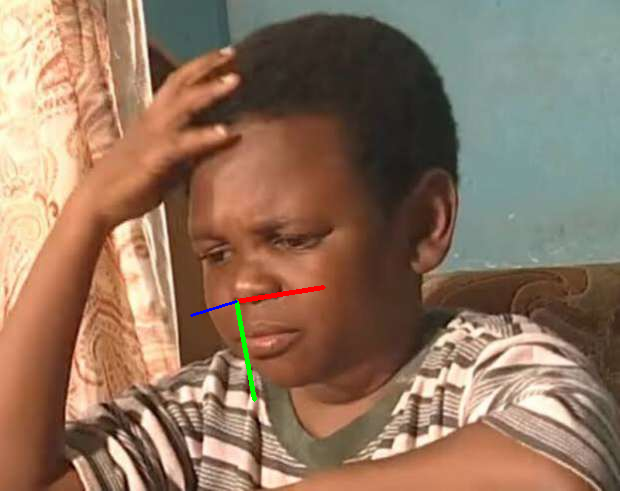

In [169]:
# making predictions on random images from the web
test_images = '/content/test_images/'
for image_name in os.listdir(test_images):
  img = cv2.imread(test_images + image_name)
  cv2_imshow(perform_prediction(pitch_model, yaw_model, roll_model, img))

## Prediction on a Video

In [177]:
cap = cv2.VideoCapture('/content/input_video.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/output.mp4', fourcc, frame_rate, (width, height))
while True:
        try:
        # Read the next frame from the video
            ret, frame = cap.read()
            if not ret:
              break
            #frame = cv2.flip(frame, 1)
            frame = perform_prediction(pitch_model, yaw_model, roll_model, frame)

            out.write(frame)
        except:
          pass
             

# Release the video capture and output object
cap.release()
out.release()

## Predictions Using Webcam

In [ ]:
cap = cv2.VideoCapture(0)
while True:
        try:
        # Read the next frame from the video
            ret, frame = cap.read()
            frame = perform_prediction(pitch_model, yaw_model, roll_model, frame)
            cv2.imshow('Camera', frame)
            if cv2.waitKey(1) == ord('q'):
              break
        except:
          pass
             

# Release the video capture and close cv22 windows
cap.release()
cv2.destroyAllWindows()